In [1]:
import ollama 
import os
from tqdm import tqdm
import torch
import signal
import random
import numpy as np
import json
import numpy as np
from PIL import Image
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from transformers import AutoProcessor, CLIPModel # pip install transformers
# jupyter notebook --ip 0.0.0.0 --port 8889 --allow-root
# kubectl port-forward dep-cvpr-7d4d4b94f9-82829 8889:8889

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The

In [2]:
base_path = '/root/home/data/hateful_memes/'
images_path = os.path.join(base_path, "img")

list_of_image_names = os.listdir(images_path)

In [3]:
def check_yes_no(text):
    # Strip any leading/trailing whitespace and convert to lowercase
    text = text.strip().lower()

    # Check if the text starts with 'yes' or 'no'
    if text.startswith("yes"):
        return 1
    elif text.startswith("no"):
        return 0
    else:
        return None  
    
class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException


def read_jsonl_file(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            entry = json.loads(line.strip())
            data.append(entry)
    return data

def load_image_and_label(entry, img_base_path):
    img_path = f"{img_base_path}/{entry['img']}"
    try:
        img = Image.open(img_path)
        label = entry['label']
        return img, label
    except FileNotFoundError:
        print(f"Image {img_path} not found.")
        return None, None


def load_dev_file(input_file):
    dev_data = {}
    with open(input_file, 'r') as infile:
        for line in infile:
            # Load each JSON line as a dictionary
            entry = json.loads(line.strip())
        
            # Use the image path as the key and the label as the value
            dev_data[entry["img"]] = entry["label"]
    return dev_data

dev_file = os.path.join(base_path, "dev.jsonl")
dev_data = load_dev_file(dev_file)

In [4]:
list_of_models = ['llava:7b', 
                  'llava:13b',
                  'llava:34b',
                  'llava-llama3',
                  'bakllava',
                  'moondream',
                  'minicpm-v',
                  'llava-phi3']

ollama.pull('llava:7b') #pull the desired model

{'status': 'success'}

In [ ]:
# Split dev_file
hateful_data = {}
nonhateful_data = {}

for key in dev_data :
    if dev_data[key] == 1 :
        hateful_data[key] = dev_data[key]
    else  :
        nonhateful_data[key] = dev_data[key]
hateful_images = list(hateful_data.keys())
nonhateful_images = list(nonhateful_data.keys())


# Prepare CLIP Model

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
device = "cuda"
model.to(device)

In [5]:
# emb1 = hateful_embeddings['img/08291.png']
# emb1_name = 'img/08291.png'
#print(len(hateful_embeddings))
emb_path='/mnt/Software/ViGIR_CVPR_LLM/prompting_framework/hateful_memes_embeddings'
#torch.save(hateful_embeddings, os.path.join(emb_path,'hateful_embeddings.pth'))
#torch.save(nonhateful_embeddings, os.path.join(emb_path,'nonhateful_embeddings.pth'))
lhe = torch.load(os.path.join(emb_path,'hateful_embeddings.pth'))
lnhe = torch.load(os.path.join(emb_path,'nonhateful_embeddings.pth'))
all_embeddings = lhe | lnhe
# print(len(all_embeddings))
def retrieve_similar(query_embedding, query_image_name, embeddings_dict):
    max_cosine_similarity = -float('inf')
    closest_image=None
    keys = list(embeddings_dict.keys())
    for key in keys:
        if query_image_name != key :
            current_embedding = embeddings_dict[key]
            # Normalize embeddings
            current_embedding = current_embedding/current_embedding.norm(p=2,dim=-1,keepdim=True)
            query_embedding = query_embedding/query_embedding.norm(p=2,dim=-1,keepdim=True)
            
            cosine_similarity = torch.nn.functional.cosine_similarity(current_embedding, query_embedding, dim=1)
            #print(cosine_similarity)
            if cosine_similarity > max_cosine_similarity :
                max_cosine_similarity = cosine_similarity
                closest_image = key
                #print(f"new max, {closest_image}, {cosine_similarity}")
        
    
    return closest_image
# print(x)
#x = retrieve_similar(emb1, emb1_name, lnhe)

In [ ]:
hateful_embeddings['img/08291.png'].shape
print(len(hateful_embeddings))
emb_path='/mnt/Software/ViGIR_CVPR_LLM/prompting_framework/hateful_memes_embeddings'
#torch.save(hateful_embeddings, os.path.join(emb_path,'hateful_embeddings.pth'))
#torch.save(nonhateful_embeddings, os.path.join(emb_path,'nonhateful_embeddings.pth'))
lhe = torch.load(os.path.join(emb_path,'hateful_embeddings.pth'))
lnhe = torch.load(os.path.join(emb_path,'nonhateful_embeddings.pth'))


In [ ]:
for 

In [ ]:
hateful_embeddings = {}
nonhateful_embeddings = {}
for image in tqdm(hateful_images) :
    img_file = os.path.join(base_path, image)
    print(f"Processing Hateful: {img_file}")
    img = Image.open(img_file)
    inputs = processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    # Move embeddings to CPU
    hateful_embeddings[image]=image_features.cpu()
    del inputs

for image in tqdm(nonhateful_images) :
    img_file = os.path.join(base_path, image)
    print(f"Processing Non-Hateful: {img_file}")
    img = Image.open(img_file) 
    inputs = processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    nonhateful_embeddings[image]=image_features.cpu()
    del inputs

In [ ]:
options= {  # new
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048, # must be set, otherwise slightly random output
        }
    
llava_7b_emb_labels = {}

np.random.seed(0)

timeout_duration = 20 # 20 seconds
print(f"Handling the timeout exceptions with timeout duration of {timeout_duration} seconds")

#for image_name in tqdm(list_of_image_names):
for key, value in dev_data.items():
    print(f"Image: {key}, Label: {value}")
    # Extract current image name
    query_img = key
    # Extract its embedding 
    query_emb = all_embeddings[key]

    # Calculate its "nearest neighbor" in hateful and non-hateful -- Ramy
    similar_hateful = retrieve_similar(query_emb, query_img, lhe)
    similar_nonhateful = retrieve_similar(query_emb, query_img, lnhe)
    
    #random_image_index = np.random.randint(0, len(dev_data))
    #random_image_path = os.path.join(base_path, images_list[random_image_index])
    
    #image_path = os.path.join(base_path, key)  
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(timeout_duration)  # Set the timeout
    
    prompt_1 = "This is  an offensive meme."
    prompt_2 = "This is not an offensive meme."
    prompt_3 = "How about this one? (Answer only Yes or No)"
    
    try:
        response_1 = ollama.generate(model='llava:7b', prompt=prompt_1, images=[os.path.join(base_path,similar_hateful)], options=options)
        response_2 = ollama.generate(model='llava:7b', prompt=prompt_2, images=[os.path.join(base_path,similar_nonhateful)], options=options, context=response_1['context'])
        response_3 = ollama.generate(model='llava:7b', prompt=prompt_3, images=[os.path.join(base_path,query_img)], options=options, context=response_2['context'])
        label = check_yes_no(response_3['response'])
    except TimeoutException:
        print(f"Prompt for {image_name} took longer than {timeout_duration} seconds. Moving to the next one.")
        label = None

    finally:
        signal.alarm(0)  # Disable the alarm

    llava_7b_emb_labels[query_img] = label
    
    print(f"model results -- Image: {query_img}, Label: {label}")
    print("------------------------------------------------------")
   

In [ ]:


class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException

# Setup options and random seed
options = {
    "seed": 123,
    "temperature": 0,
    "num_ctx": 2048,
}
np.random.seed(0)
timeout_duration = 20  # 20 seconds

# Initialize the labels dictionary
llava_7b_emb_labels = {}

# Assign the signal handler for the timeout
signal.signal(signal.SIGALRM, timeout_handler)
print(f"Handling the timeout exceptions with a timeout duration of {timeout_duration} seconds")

for query_img, value in tqdm(dev_data.items()):
    print(f"Image: {query_img}, Label: {value}")

    # Extract embedding
    query_emb = all_embeddings[query_img]

    # Find nearest neighbors
    similar_hateful = retrieve_similar(query_emb, query_img, lhe)
    similar_nonhateful = retrieve_similar(query_emb, query_img, lnhe)

    # Prompts
    prompt_1 = "This is a meme image. The combination of its text and image content is offensive/ hateful. Learn from this."
    prompt_2 = "This is a meme image. The combination of its text and image content is not offensive/ hateful. Learn from this."
    prompt_3 = "How about this one? (Answer only Yes or No)"

    # Set the alarm for timeout
    signal.alarm(timeout_duration)
    try:
        response_1 = ollama.generate(
            model='llava:7b', prompt=prompt_1, images=[os.path.join(base_path, similar_hateful)], options=options
        )
        if 'context' not in response_1 :
            label = None
            llava_7b_emb_labels[query_img] = label
            continue
        response_2 = ollama.generate(
            model='llava:7b', prompt=prompt_2, images=[os.path.join(base_path, similar_nonhateful)], options=options, context=response_1['context']
        )
        if 'context' not in response_2 :
            label = None
            llava_7b_emb_labels[query_img] = label
            continue
        response_3 = ollama.generate(
            model='llava:7b', prompt=prompt_3, images=[os.path.join(base_path, query_img)], options=options, context=response_2['context']
        )
        if 'context' not in response_3 :
            label = None
            llava_7b_emb_labels[query_img] = label
            continue
            
        label = check_yes_no(response_3['response'])
    except TimeoutException:
        print(f"Prompt for {query_img} took longer than {timeout_duration} seconds. Moving to the next one.")
        label = None
    finally:
        signal.alarm(0)  # Disable the alarm

    # Store the result
    llava_7b_emb_labels[query_img] = label
    
    print(f"Model results -- Image: {query_img}, Label: {label}")
    print("------------------------------------------------------")


Handling the timeout exceptions with a timeout duration of 20 seconds


  0%|                                                                                                                  | 0/500 [00:00<?, ?it/s]

Image: img/08291.png, Label: 1


  0%|▏                                                                                                       | 1/500 [00:08<1:08:52,  8.28s/it]

Model results -- Image: img/08291.png, Label: 0
------------------------------------------------------
Image: img/46971.png, Label: 1


  0%|▍                                                                                                       | 2/500 [00:15<1:01:45,  7.44s/it]

Model results -- Image: img/46971.png, Label: 1
------------------------------------------------------
Image: img/03745.png, Label: 1


  1%|▋                                                                                                         | 3/500 [00:21<57:02,  6.89s/it]

Model results -- Image: img/03745.png, Label: 1
------------------------------------------------------
Image: img/83745.png, Label: 1


  1%|▊                                                                                                         | 4/500 [00:27<53:19,  6.45s/it]

Model results -- Image: img/83745.png, Label: 1
------------------------------------------------------
Image: img/80243.png, Label: 1


  1%|█                                                                                                         | 5/500 [00:30<45:13,  5.48s/it]

Model results -- Image: img/80243.png, Label: 1
------------------------------------------------------
Image: img/05279.png, Label: 1


  1%|█▎                                                                                                        | 6/500 [00:38<49:57,  6.07s/it]

Model results -- Image: img/05279.png, Label: 1
------------------------------------------------------
Image: img/01796.png, Label: 1


  1%|█▍                                                                                                        | 7/500 [00:43<48:45,  5.93s/it]

Model results -- Image: img/01796.png, Label: 1
------------------------------------------------------
Image: img/53046.png, Label: 1


  2%|█▋                                                                                                        | 8/500 [00:47<42:03,  5.13s/it]

Model results -- Image: img/53046.png, Label: 0
------------------------------------------------------
Image: img/82301.png, Label: 1


  2%|█▉                                                                                                        | 9/500 [00:53<45:19,  5.54s/it]

Model results -- Image: img/82301.png, Label: 1
------------------------------------------------------
Image: img/31752.png, Label: 1


  2%|██                                                                                                       | 10/500 [01:00<47:33,  5.82s/it]

Model results -- Image: img/31752.png, Label: 0
------------------------------------------------------
Image: img/27635.png, Label: 1


  2%|██▎                                                                                                      | 11/500 [01:05<45:38,  5.60s/it]

Model results -- Image: img/27635.png, Label: 1
------------------------------------------------------
Image: img/80597.png, Label: 1


  2%|██▌                                                                                                      | 12/500 [01:10<43:50,  5.39s/it]

Model results -- Image: img/80597.png, Label: 0
------------------------------------------------------
Image: img/45368.png, Label: 1


  3%|██▋                                                                                                      | 13/500 [01:15<44:17,  5.46s/it]

Model results -- Image: img/45368.png, Label: 0
------------------------------------------------------
Image: img/17963.png, Label: 1


  3%|██▉                                                                                                      | 14/500 [01:21<44:07,  5.45s/it]

Model results -- Image: img/17963.png, Label: 1
------------------------------------------------------
Image: img/53968.png, Label: 1


  3%|███▏                                                                                                     | 15/500 [01:25<41:46,  5.17s/it]

Model results -- Image: img/53968.png, Label: 1
------------------------------------------------------
Image: img/10749.png, Label: 1


  3%|███▎                                                                                                     | 16/500 [01:32<44:45,  5.55s/it]

Model results -- Image: img/10749.png, Label: 1
------------------------------------------------------
Image: img/25149.png, Label: 1


  3%|███▌                                                                                                     | 17/500 [01:39<48:55,  6.08s/it]

Model results -- Image: img/25149.png, Label: 1
------------------------------------------------------
Image: img/87520.png, Label: 1


  4%|███▊                                                                                                     | 18/500 [01:45<49:04,  6.11s/it]

Model results -- Image: img/87520.png, Label: 1
------------------------------------------------------
Image: img/89071.png, Label: 1


  4%|███▉                                                                                                     | 19/500 [01:52<50:16,  6.27s/it]

Model results -- Image: img/89071.png, Label: 1
------------------------------------------------------
Image: img/09563.png, Label: 1


  4%|████▏                                                                                                    | 20/500 [01:58<51:17,  6.41s/it]

Model results -- Image: img/09563.png, Label: 1
------------------------------------------------------
Image: img/72048.png, Label: 1


  4%|████▍                                                                                                    | 21/500 [02:05<51:05,  6.40s/it]

Model results -- Image: img/72048.png, Label: 1
------------------------------------------------------
Image: img/49826.png, Label: 1


  4%|████▌                                                                                                    | 22/500 [02:12<52:13,  6.55s/it]

Model results -- Image: img/49826.png, Label: 0
------------------------------------------------------
Image: img/26453.png, Label: 1


  5%|████▊                                                                                                    | 23/500 [02:16<46:33,  5.86s/it]

Model results -- Image: img/26453.png, Label: 1
------------------------------------------------------
Image: img/12650.png, Label: 1


  5%|█████                                                                                                    | 24/500 [02:21<44:20,  5.59s/it]

Model results -- Image: img/12650.png, Label: 0
------------------------------------------------------
Image: img/02568.png, Label: 1


  5%|█████▎                                                                                                   | 25/500 [02:28<46:40,  5.90s/it]

Model results -- Image: img/02568.png, Label: 0
------------------------------------------------------
Image: img/83954.png, Label: 1


  5%|█████▍                                                                                                   | 26/500 [02:34<47:21,  6.00s/it]

Model results -- Image: img/83954.png, Label: 1
------------------------------------------------------
Image: img/24316.png, Label: 1


  5%|█████▋                                                                                                   | 27/500 [02:40<47:15,  6.00s/it]

Model results -- Image: img/24316.png, Label: 0
------------------------------------------------------
Image: img/62035.png, Label: 1


  6%|█████▉                                                                                                   | 28/500 [02:46<48:32,  6.17s/it]

Model results -- Image: img/62035.png, Label: 1
------------------------------------------------------
Image: img/65342.png, Label: 1


  6%|██████                                                                                                   | 29/500 [02:50<41:54,  5.34s/it]

Model results -- Image: img/65342.png, Label: 1
------------------------------------------------------
Image: img/92058.png, Label: 1


  6%|██████▎                                                                                                  | 30/500 [02:57<47:04,  6.01s/it]

Model results -- Image: img/92058.png, Label: 1
------------------------------------------------------
Image: img/58672.png, Label: 1


  6%|██████▌                                                                                                  | 31/500 [03:01<42:06,  5.39s/it]

Model results -- Image: img/58672.png, Label: 1
------------------------------------------------------
Image: img/54069.png, Label: 1


  6%|██████▋                                                                                                  | 32/500 [03:06<41:18,  5.30s/it]

Model results -- Image: img/54069.png, Label: 1
------------------------------------------------------
Image: img/91586.png, Label: 1


  7%|██████▉                                                                                                  | 33/500 [03:13<44:03,  5.66s/it]

Model results -- Image: img/91586.png, Label: 1
------------------------------------------------------
Image: img/87130.png, Label: 1


  7%|███████▏                                                                                                 | 34/500 [03:16<38:54,  5.01s/it]

Model results -- Image: img/87130.png, Label: 1
------------------------------------------------------
Image: img/95640.png, Label: 1


  7%|███████▎                                                                                                 | 35/500 [03:20<36:14,  4.68s/it]

Model results -- Image: img/95640.png, Label: 0
------------------------------------------------------
Image: img/47819.png, Label: 1


  7%|███████▌                                                                                                 | 36/500 [03:24<34:43,  4.49s/it]

Model results -- Image: img/47819.png, Label: 1
------------------------------------------------------
Image: img/59140.png, Label: 1


  7%|███████▊                                                                                                 | 37/500 [03:28<32:11,  4.17s/it]

In [12]:
if 'context' not in response_2:
    print(response_2['response'])
    print("no context")

 The image you've shared appears to be a collage of three separate photos, each with its own context.

The top photo shows a person in a yamaka (kippah) standing next to another person dressed in formal or ceremonial clothing, possibly representing a politician or public figure. The text on this photo reads: "Busy like life of bees, controlling what you see and edit all the news you see." This is a play on words, suggesting that the person in the yamaka has significant influence over media narratives, which is a common stereotype about Jewish individuals.

The middle photo shows two people dressed as Santa Claus and an elf, likely representing Christmas celebrations. The text on this photo reads: "Everyone celebrates Christmas!" This statement is factual and does not contain any offensive content.

The bottom photo features two men dressed in traditional Jewish attire, including tallisim (prayer shawls) and black hats, walking together. The text on this photo reads: "Everyone celebrate

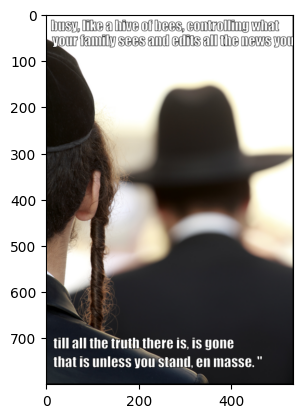

In [14]:
img  = Image.open(os.path.join(base_path, similar_hateful))
plt.imshow(img)
plt.show()

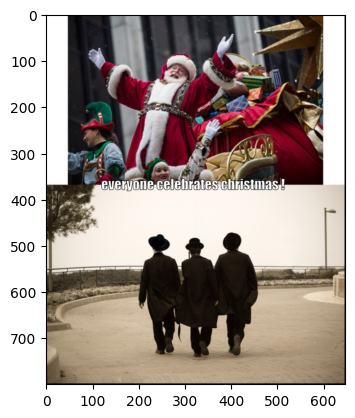

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
img  = Image.open(os.path.join(base_path, similar_nonhateful))
plt.imshow(img)
plt.show()

In [ ]:
# Experiment 3 | two prompts

options= {  # new
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048, # must be set, otherwise slightly random output
        }
    
labels_2context_dict = {}

np.random.seed(0)
for model in list_of_models :
    for entry in tqdm(dev_data):
        rand_hateful_index = np.random.randint(0, len(gt_hateful))
        rand_not_hateful_index = np.random.randint(0, len(gt_not_hateful))
        
        hateful_path = os.path.join(base_path, "img", gt_hateful[rand_hateful_index])
        not_hateful_path = os.path.join(base_path, "img", gt_not_hateful[rand_not_hateful_index])
        
        image_path = os.path.join(base_path, entry['img'])
        
        prompt_1 = "This is a offensive meme."
        prompt_2 = "This is not a offensive meme. "
        prompt_3 = "Based on the two previous prompts. Is this an offensive meme? answer either yes or no?. "
    
        
        response_1 = ollama.generate(model=model, prompt=prompt_1, images=[hateful_path], options=options)
        response_2 = ollama.generate(model=model, prompt=prompt_2, images=[not_hateful_path], options=options, context=response_1['context'])
        response_3 = ollama.generate(model=model, prompt=prompt_3, images=[image_path], options=options, context=response_2['context'])
    
        label_2context = check_yes_no(response_3['response'])
    
        image_name =  os.path.basename(entry['img'])
        print(label_2context, '--', entry['label'], '--', entry['img'], '--', image_name)
    
        labels_2context_dict[image_name] = label_2context
        break

In [ ]:

def compute_metrics(gt, predictions, name, output_file="metrics.csv"):
    # Ensure we only evaluate on common keys
    common_keys = set(gt.keys()).intersection(predictions.keys())
    
    # Extract lists of labels based on the common keys, filtering out None values
    y_true = []
    y_pred = []
    for key in common_keys:
        pred_label = predictions[key]
        if pred_label is not None:
            y_true.append(gt[key])
            y_pred.append(pred_label)
    
    # Check if there are valid entries left after filtering
    if y_true and y_pred:
        # Calculate metrics
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        accuracy = accuracy_score(y_true, y_pred)
        
        # Create a DataFrame to store the results
        metrics_df = pd.DataFrame({
            "Model": [name],
            "Precision": [precision],
            "Recall": [recall],
            "F1 Score": [f1],
            "Accuracy": [accuracy]
        })
        
        # Display the table
        print(metrics_df)
        
        # Save to a file (append if file already exists)
        with open(output_file, "a") as f:
            metrics_df.to_csv(f, index=False, header=f.tell()==0)
    else:
        print(f"No valid entries to compute metrics for {name}")

# Example usage
# compute_metrics(gt_dict, predictions_dict, 'Model Metrics')
